In [8]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

In [2]:
# Sample dataset
data = pd.DataFrame({
    'x1': np.random.normal(0, 1, 100),
    'x2': np.random.normal(0, 1, 100),
    'x3': np.random.normal(0, 1, 100),
    'y': np.random.binomial(1, 0.5, 100)
})

# Logistic regression model
with pm.Model() as logistic_regression:
    # Priors for the model parameters
    beta0 = pm.Normal('beta0', 0, 1)
    beta1 = pm.Normal('beta1', 0, 1)
    beta2 = pm.Normal('beta2', 0, 1)
    beta3 = pm.Normal('beta3', 0, 1)

    # Logistic regression function
    p = pm.math.invlogit(beta0 + beta1*data['x1'] + beta2*data['x2'] + beta3*data['x3'])

    # Likelihood
    y = pm.Bernoulli('y', p, observed=data['y'])

    # Inference
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [4]:
summary = pm.summary(trace)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0 -0.226  0.208  -0.612    0.159      0.002    0.002    6957.0    3430.0   
beta1 -0.228  0.213  -0.607    0.189      0.003    0.003    4837.0    3116.0   
beta2 -0.359  0.206  -0.759    0.016      0.003    0.002    6032.0    3326.0   
beta3  0.179  0.194  -0.177    0.559      0.002    0.002    6420.0    3356.0   

       r_hat  
beta0    1.0  
beta1    1.0  
beta2    1.0  
beta3    1.0  


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'beta3'}>,
        <AxesSubplot:title={'center':'beta3'}>]], dtype=object)

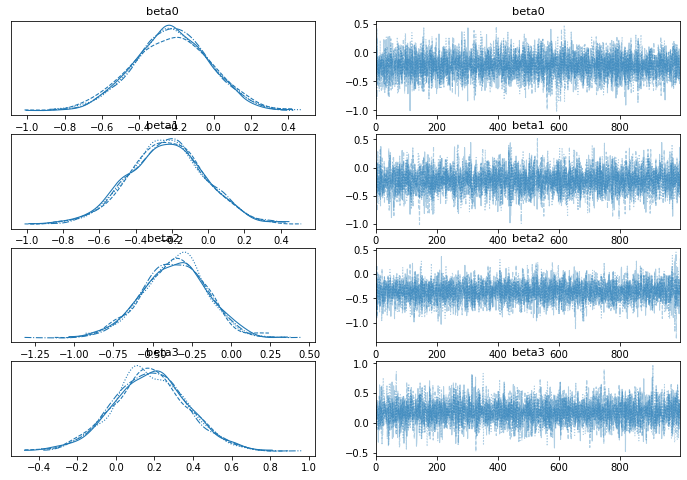

In [9]:
az.plot_trace(trace)

In [18]:
ppc = pm.sample_posterior_predictive(trace, model=logistic_regression)
y_pred = ppc.quantile(0.5)

Sampling: [y]


In [22]:
y_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [27]:
from sklearn.metrics import roc_curve

# Obtain the predicted probability of y=1 for each observation
pred_proba = y_pred

# Compute the false positive rate and true positive rate
# fpr, tpr, _ = roc_curve(data['y'], pred_proba)
fpr, tpr, thresholds = roc_curve(data["y"], np.repeat(pred_proba, 100))

ValueError: Found input variables with inconsistent numbers of samples: [100, 200]

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    with pm.Model() as logistic_regression:
        # Priors for the model parameters
        beta0 = pm.Normal('beta0', 0, 1)
        beta1 = pm.Normal('beta1', 0, 1)
        beta2 = pm.Normal('beta2', 0, 1)
        beta3 = pm.Normal('beta3', 0, 1)

        # Logistic regression function
        p = pm.math.invlogit(beta0 + beta1*train_data['x1'] + beta2*train_data['x2'] + beta3*train_data['x3'])

        # Likelihood
        y = pm.Bernoulli('y', p, observed=train_data['y'])

        # Inference
        trace = pm.sample()
    ppc = pm.sample_posterior_predictive(trace, model=logistic_regression)
    y_pred = ppc['y']
    scores.append(accuracy_score(test_data['y'], y_pred))
print(np.mean(scores))

In [20]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data